In [1]:
#Get tide height for every image in Landsat collections? Might be trickiest step
#Plot: percentage of pixels inundated over time, within flux tower footprint (BUT will depend on tidal height)

In [2]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [3]:
import glob
import pandas as pd
##PC:
path = r'C:/Users/arj26323/Documents/Data/flats/Tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_tides = pd.concat(li, axis=0, ignore_index=True)

df_tides

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m)
0,1985/01/02,00:00,0.891,-,1.007
1,1985/01/02,01:00,0.540,-,0.681
2,1985/01/02,02:00,0.275,-,0.418
3,1985/01/02,03:00,0.187,-,0.354
4,1985/01/02,04:00,0.332,-,0.507
...,...,...,...,...,...
350635,1985/01/01,19:00,1.456,-,1.65
350636,1985/01/01,20:00,1.658,-,1.763
350637,1985/01/01,21:00,1.693,-,1.695
350638,1985/01/01,22:00,1.547,-,1.555


In [4]:
import seaborn as sns

dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=dims)
# g = sns.lineplot(ax = ax, x = "Date", y = "Predicted (m)", color = "b", data = df)


In [5]:
df2 = df_tides.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

df_time = df2.copy()
df_time['Verified (m)'] = df_time['Verified (m)'].replace('-', float('nan')).astype('float')
df_time = df_time.dropna()
df_time['Tide change'] = df_time['Verified (m)'].diff()
df_time['Tide stage'] = df_time['Tide change'].apply(lambda x: 'Ebb' if x < 0 else 'Flood')

time_mask = (df_time['Time (GMT)'].dt.hour == 16)

df_time = df_time[time_mask]

df_time

C:\Users\arj26323\AppData\Local\Temp\ipykernel_13188\1366120865.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])


,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY,Tide change,Tide stage
16,1985/01/02,2023-12-07 16:00:00,0.340,-,0.479,1985-01-02,0.018,Flood
40,1985/01/03,2023-12-07 16:00:00,0.275,-,0.406,1985-01-03,-0.159,Ebb
64,1985/01/04,2023-12-07 16:00:00,0.374,-,0.458,1985-01-04,-0.448,Ebb
88,1985/01/05,2023-12-07 16:00:00,0.620,-,0.543,1985-01-05,-0.363,Ebb
112,1985/01/06,2023-12-07 16:00:00,0.967,-,1.162,1985-01-06,-0.381,Ebb
...,...,...,...,...,...,...,...,...
350536,1984/12/28,2023-12-07 16:00:00,1.759,-,1.830,1984-12-28,0.412,Flood
350560,1984/12/29,2023-12-07 16:00:00,1.466,-,1.449,1984-12-29,0.345,Flood
350584,1984/12/30,2023-12-07 16:00:00,1.148,-,1.104,1984-12-30,0.317,Flood
350608,1984/12/31,2023-12-07 16:00:00,0.835,-,0.927,1984-12-31,0.329,Flood


In [6]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

In [7]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss) OR all gce (gce_clip)

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_sapelodissolve.shp'

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/2014-climatology.shp'

gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

#Spartina height forms
ss_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/SS.shp')
sm_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/SM.shp')
st_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/ST.shp')
mud_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/mud.shp')

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

In [8]:
Map.addLayer(flux_ga)
Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [9]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 1946,
 'QA_RADSAT': 1946,
 'SR_ATMOS_OPACITY': 1946,
 'SR_B1': 1946,
 'SR_B2': 1946,
 'SR_B3': 1946,
 'SR_B4': 1946,
 'SR_B5': 1946,
 'SR_B7': 1946,
 'SR_CLOUD_QA': 1453,
 'ST_ATRAN': 1946,
 'ST_B6': 1946,
 'ST_CDIST': 1946,
 'ST_DRAD': 1946,
 'ST_EMIS': 1946,
 'ST_EMSD': 1946,
 'ST_QA': 1946,
 'ST_TRAD': 1946,
 'ST_URAD': 1946}

In [10]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))


#NOTE: above is 7-9 calibration; below is 8-9 calibration

# def addFLATSL9(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(1.51 + 12.5*(0.945*(RED-SWIR)/(RED+SWIR) - 0.055) - 41.2*(0.974* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.0005)))', {
#             'SWIR': image.select('SR_B6'),
#             'NIR': image.select('SR_B5'),
#             'RED': image.select('SR_B4'),
#             'BLUE': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))


##NOTE: original flats:

# def addFLATS(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B6'),
#             'RED': image.select('SR_B4'),
#             'GREEN': image.select('SR_B3')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATSL5(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B5'),
#             'RED': image.select('SR_B3'),
#             'GREEN': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#NDVI
def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addndviL5(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

#12/01/22
#VARI
def addvariL5(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(vari.rename('vari'))

def addvari(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(vari.rename('vari'))


#GLI
def addgliL5(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(gli.rename('gli'))

def addgli(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(gli.rename('gli'))

In [11]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [12]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [13]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [14]:
# #Percentage of pixels in study area flagged

# ##NOTE: CHECK WHICH VEG HEIGHT FORM IMAGE IS CLIPPED TO

# def calculate_percentage(image):
# #     image = image.clip(st_gce) #CLIP TO HEIGHT FORM OF SPARTINA - MAKE SURE TO UNCOMMENT IF REQUIRED
    
#     # Select the "flats" band
#     flats_band = image.select('flats')
    
#     # Create a binary mask where pixels with values above 0.2 are set to 1, others to 0
#     threshold_mask = flats_band.gt(0.2)
    
#     # Calculate the total count of pixels within the area defined by flux_ga - DONE FIRST, BEFORE MASK
#     total_pixel_count = image.reduceRegion(
#         reducer=ee.Reducer.count(),
#         geometry=flux_ga,
#         scale=30  # Adjust scale as needed, e.g., 30 meters for Landsat
#     ).get('flats')
      
#     # Mask the image with the threshold mask - DONE AFTER FIRST REDUCE REGION
#     image2 = image.updateMask(threshold_mask)
    
#     # Calculate the count of pixels above 0.2 within the area defined by flux_ga
#     above_threshold_count = image2.reduceRegion(
#         reducer=ee.Reducer.count(),
#         geometry=flux_ga,
#         scale=30  # Adjust scale as needed
#     ).get('flats')
    
#     # Calculate the percentage
#     percentage = ee.Number(above_threshold_count).divide(total_pixel_count).multiply(100)
    
#     return image.set('percentage_flood', percentage).set('total_pixel_count', total_pixel_count)


# # Map the function over the image collection
# perflood_l8 = l8_col.map(calculate_percentage)

# # Get the list of dates and percentages
# dates = perflood_l8.aggregate_array('system:time_start')
# percentages = perflood_l8.aggregate_array('percentage_flood')
# total_pixel_counts = perflood_l8.aggregate_array('total_pixel_count')

# # Convert the dates, percentages, and total pixel counts to lists
# dates_list = dates.getInfo()
# percentages_list = percentages.getInfo()
# total_pixel_counts_list = total_pixel_counts.getInfo()

# # Create a DataFrame
# df8 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# # Convert the Date column to datetime
# df8['Date'] = pd.to_datetime(df8['Date'], unit='ms')

# # Sort the DataFrame by Date
# df8 = df8.sort_values(by='Date')

In [15]:
#Percentage of pixels in study area flagged WITH ELEVATION THRESHOLDS

def calculate_percentage(image):
    # Select the "flats" band
    flats_band = image.select('flats')
    
    # Load the elevation band from the image
    elevation_band = image.select('elevation')
    
    # Define the different thresholds based on elevation
    threshold_below_elevation = 0.2
    threshold_above_elevation = 0.8

    # Condition for masking based on elevation using expression()
    threshold_mask = flats_band.expression(
        "(elev >= 0.85) ? flats > threshold_above : flats > threshold_below",
        {
            'elev': image.select('elevation'), 
            'flats': flats_band,
            'threshold_above': threshold_above_elevation,
            'threshold_below': threshold_below_elevation
        }
    )

    # Calculate the total count of pixels within the area defined by flux_ga
    total_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=flux_ga,
        scale=30
    ).get('flats')
      
    # Mask the image with the elevation-dependent threshold mask
    image2 = image.updateMask(threshold_mask)
    
    # Calculate the count of pixels above the threshold within the area defined by flux_ga
    above_threshold_count = image2.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=flux_ga,
        scale=30
    ).get('flats')
    
    # Calculate the percentage
    percentage = ee.Number(above_threshold_count).divide(total_pixel_count).multiply(100)
    
    return image.set('percentage_flood', percentage).set('total_pixel_count', total_pixel_count)


# Map the function over the image collection
perflood_l8 = l8_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l8.aggregate_array('system:time_start')
percentages = perflood_l8.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l8.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df8 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df8['Date'] = pd.to_datetime(df8['Date'], unit='ms')

# Sort the DataFrame by Date
df8 = df8.sort_values(by='Date')

In [16]:
list_l8 = perflood_l8.toList(perflood_l8.size())

x = ee.Image(list_l8.get(0))

vis_param = {'min': 0, 
             'max': 0.5, 
             'bands': ['SR_B5', 'SR_B4', 'SR_B3'], 
             'gamma': 1.5}

# Map.addLayer(x, vis_param, 'SR')

# Map.addLayer(x, {'bands': ['flats'], 'min': 0, 'max': 1}, 'FLATS')

# Map.addLayer(flux_ga)


In [17]:
# dfw = df8[df8['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes

# import seaborn as sns
# ax = sns.lineplot(
#     x="Date",
#     y="Percentage",
#     legend=False,
#     marker = 'o',
#     data=dfw
# )

# plt.ylabel("Percent of pixels flooded")

# plt.tight_layout()


In [18]:
# dfw

In [19]:
# top_20 = df8.nlargest(20, 'Percentage')

# print(top_20) #CHECK to see if high percentage just caused by low total number of pixels due to cloud maskig
#May not be representative if clouds cover much of scene

#Earlier - way of filtering out low-pixel scenes

In [20]:
# Landsat 5
perflood_l5 = l5_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l5.aggregate_array('system:time_start')
percentages = perflood_l5.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l5.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df5 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df5['Date'] = pd.to_datetime(df5['Date'], unit='ms')

# Sort the DataFrame by Date
df5 = df5.sort_values(by='Date')


In [21]:
# Landsat 7
perflood_l7 = l7_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l7.aggregate_array('system:time_start')
percentages = perflood_l7.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l7.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df7 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df7['Date'] = pd.to_datetime(df7['Date'], unit='ms')

# Sort the DataFrame by Date
df7 = df7.sort_values(by='Date')

In [22]:
#Landsat 9
perflood_l9 = l9_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l9.aggregate_array('system:time_start')
percentages = perflood_l9.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l9.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df9 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df9['Date'] = pd.to_datetime(df9['Date'], unit='ms')

# Sort the DataFrame by Date
df9 = df9.sort_values(by='Date')

In [23]:
df = pd.concat([df5,df7,df8,df9], axis=0)
df = df.reset_index(drop=True)

df['DOY'] = df['Date'].dt.strftime('%Y-%m-%d')
df['DOY'] = pd.to_datetime(df['DOY'])
df

# print(df.dtypes)

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-04-12 15:21:47.367,6.854839,248,1984-04-12
1,1984-04-19 15:27:58.365,27.235355,1946,1984-04-19
2,1984-05-05 15:28:05.134,2.877698,1946,1984-05-05
3,1984-05-14 15:22:12.295,7.965057,1946,1984-05-14
4,1984-05-21 15:28:35.468,2.962085,1688,1984-05-21
...,...,...,...,...
1690,2023-09-30 16:00:50.784,0.000000,0,2023-09-30
1691,2023-10-09 15:54:46.385,18.345324,1946,2023-10-09
1692,2023-10-16 16:01:02.494,0.000000,0,2023-10-16
1693,2023-11-01 16:00:56.167,92.838055,1871,2023-11-01


In [24]:
df_all = df[df['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes

# plt.figure(figsize=(15, 6))


# import seaborn as sns
# ax = sns.scatterplot(
#     x="Date",
#     y="Percentage",
#     legend=False,
#     marker = 'o',
#     data=df_all
# )

# plt.ylabel("Percent of pixels flooded")


# plt.tight_layout()

In [25]:
df_all

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-04-12 15:21:47.367,6.854839,248,1984-04-12
1,1984-04-19 15:27:58.365,27.235355,1946,1984-04-19
2,1984-05-05 15:28:05.134,2.877698,1946,1984-05-05
3,1984-05-14 15:22:12.295,7.965057,1946,1984-05-14
4,1984-05-21 15:28:35.468,2.962085,1688,1984-05-21
...,...,...,...,...
1690,2023-09-30 16:00:50.784,0.000000,0,2023-09-30
1691,2023-10-09 15:54:46.385,18.345324,1946,2023-10-09
1692,2023-10-16 16:01:02.494,0.000000,0,2023-10-16
1693,2023-11-01 16:00:56.167,92.838055,1871,2023-11-01


In [26]:
df_combined = pd.merge(df, df_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
# df_combined

In [27]:
df_ultra = df_combined[df_combined['Total_Pixel_Count'] >= 0] #Filter out low pixel-scenes, approx. half (CHECK PIX COUNT)

# plt.figure(figsize=(12, 6))

# import seaborn as sns
# ax = sns.scatterplot(
#     x="Date",
#     y="Percentage",
#     legend=False,
#     marker = 'o',
#     data=df_ultra
# )

# plt.ylabel("Percent of pixels flooded")
# plt.xlabel("")

# plt.tight_layout()

# plt.savefig('fluxproper_flooding.png', bbox_inches='tight', dpi = 300)

In [28]:
# sns.lineplot(x='Date', y='Percentage', data=df_ultra, hue='Verified (m)', ci=None)
# plt.xlabel('Year')
# plt.ylabel('Percent Flooded')
# plt.title('Percent Flooded ~ Year (Tide Height)')
# plt.show()


# df_ultra['Verified (m)'] = df_ultra['Verified (m)'].replace('-', float('nan'))

# df_ultra['Verified (m)'] = df_ultra['Verified (m)'].astype('float')

# df_ultra.dropna()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_ultra['Percentage'])


In [29]:
# import statsmodels.api as sm

# Add a constant term to the DataFrame for the intercept
df_x = df_ultra.copy()

df_x['Verified (m)'] = df_x['Verified (m)'].replace('-', float('nan')).astype('float')

df_x = df_x.dropna()

df_x['Date'] = pd.to_datetime(df_x['Date'])

df_x['intercept'] = 1

# df_x['Trans_per'] =

# # Create a linear regression model
# model = sm.OLS(df_x['Percentage'], df_x[['Date', 'Verified (m)', 'intercept']])

# # Fit the model
# results = model.fit()

# # Print the summary statistics
# print(results.summary())


In [30]:
# df_x.dtypes

In [31]:
# df_x.isnull().sum()


In [32]:
# df_x['Verified (m)'].describe()

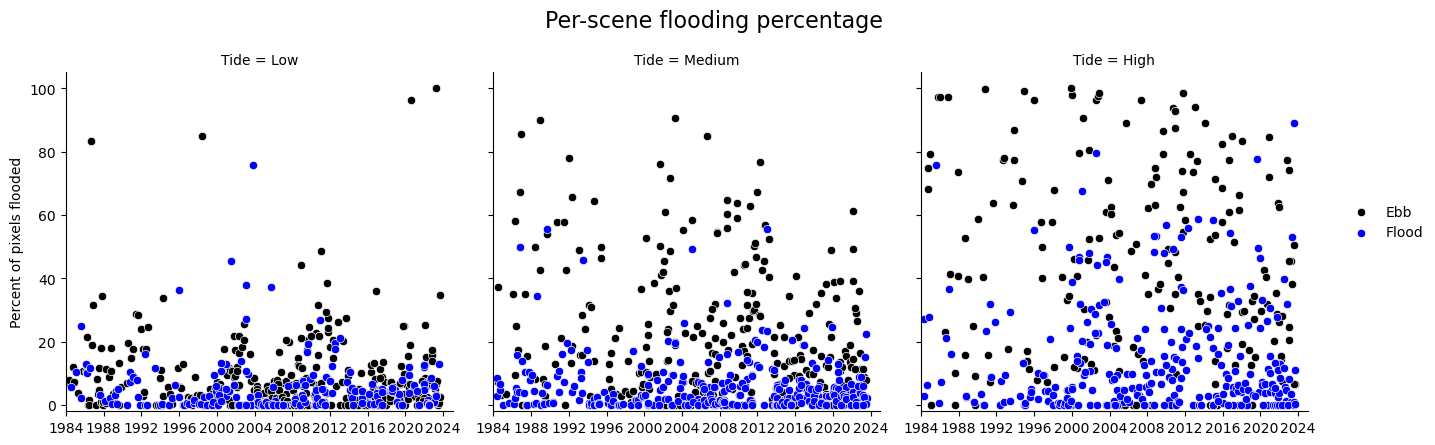

In [33]:
# Create a facet grid for 'Verified (m)' categories

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.8, 1.8, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[df_x['Tide stage'] == 'Flood']

g = sns.FacetGrid(df_x, col="Tide", hue = 'Tide stage', col_wrap=3, height=4.5, palette={'Ebb': 'black', 'Flood': 'blue'}) 
# g = sns.FacetGrid(df_y, col="Tide", col_wrap=3, height=4) 
g.map(sns.scatterplot, "Date", "Percentage", marker='o', legend=False)

# Set axis labels and adjust layout
g.set_axis_labels("", "Percent of pixels flooded")
plt.suptitle('Per-scene flooding percentage', fontsize=16)

g.add_legend(title='')

g.set(ylim=(-2, 105))  # Set the y-axis limits
g.set(xlim=(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31')))
g.tight_layout()

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# g.savefig('cerf_variablethresholds.png', bbox_inches='tight', dpi = 300)

plt.show()

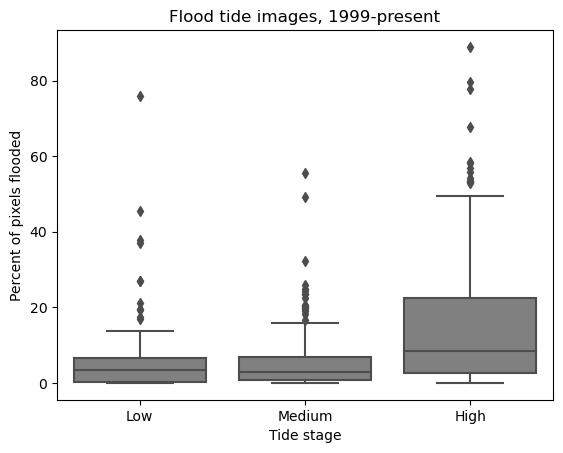

In [34]:
# Boxplotting

fig, ax = plt.subplots()

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.8, 1.8, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[(df_x['Tide stage'] == 'Flood') & (df_x['Date'].dt.year > 1999)]

g = sns.boxplot(df_y, x = 'Tide', y = 'Percentage', color = 'gray', ax = ax).set(
    xlabel='Tide stage', 
    ylabel='Percent of pixels flooded',
    title='Flood tide images, 1999-present'
)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('boxplot1.png', bbox_inches='tight', dpi = 300)

plt.show()

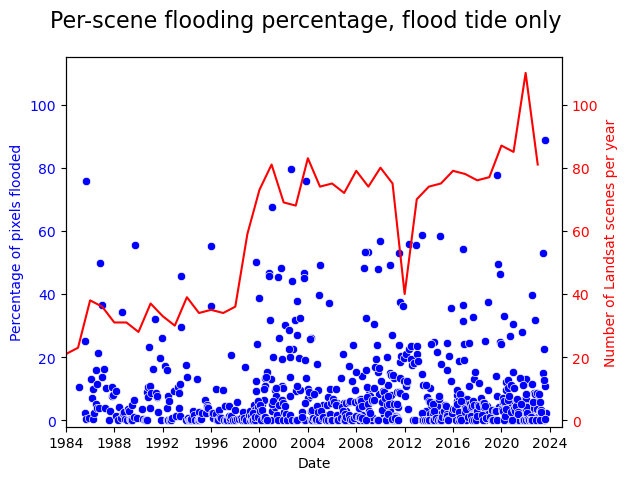

In [35]:
#Flood tide only!
# Create a facet grid for 'Verified (m)' categories

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.8, 1.8, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[(df_x['Tide stage'] == 'Flood') & (df_x['Date'].dt.year > 1984)]

df_imcount = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/imcount.csv')
df_imcount['Date'] = pd.to_datetime(df_imcount['Year'], format = '%Y')


fig, ax1 = plt.subplots()

# Scatter plot for df_y
sns.scatterplot(data=df_y, x="Date", y="Percentage", marker='o', color='blue', ax=ax1)
ax1.set_ylabel("Percentage of pixels flooded", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.ylim(-2, 115)

# Create a twin y-axis for df_imcount
ax2 = ax1.twinx()
sns.lineplot(data=df_imcount, x="Date", y="Image Count", color='red', ax=ax2)  # Replace 'YourImCountColumn' with the appropriate column from df_imcount
ax2.set_ylabel("Number of Landsat scenes per year", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.suptitle('Per-scene flooding percentage, flood tide only', fontsize=16)
plt.xlim(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31'))
plt.ylim(-2, 115)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('cerf_variablethresholds2.png', bbox_inches='tight', dpi = 300)

plt.show()

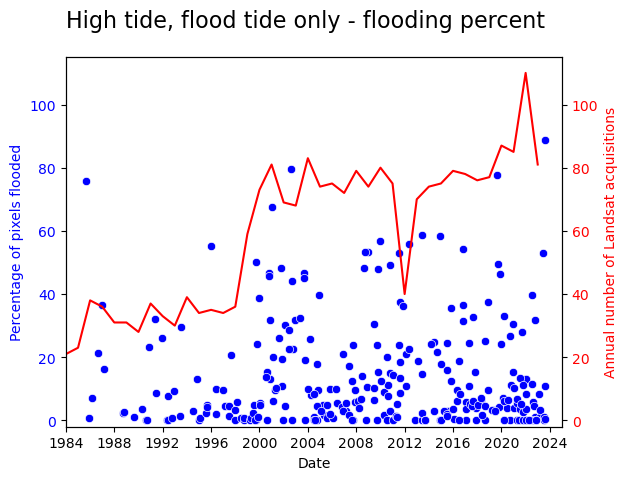

In [36]:
#Flood tide only, high tide only!
# Create a facet grid for 'Verified (m)' categories

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.8, 1.8, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[(df_x['Tide stage'] == 'Flood') & (df_x['Date'].dt.year > 1984) & (df_x['Tide'] == 'High')]

df_imcount = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/imcount.csv')
df_imcount['Date'] = pd.to_datetime(df_imcount['Year'], format = '%Y')

fig, ax1 = plt.subplots()

# Scatter plot for df_y
sns.scatterplot(data=df_y, x="Date", y="Percentage", marker='o', color='blue', ax=ax1)
ax1.set_ylabel("Percentage of pixels flooded", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.ylim(-2, 115)

# Create a twin y-axis for df_imcount
ax2 = ax1.twinx()
sns.lineplot(data=df_imcount, x="Date", y="Image Count", color='red', ax=ax2)  # Replace 'YourImCountColumn' with the appropriate column from df_imcount
ax2.set_ylabel("Annual number of Landsat acquisitions", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.suptitle('High tide, flood tide only - flooding percent', fontsize=16)
plt.xlim(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31'))
plt.ylim(-2, 115)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('datadensity.png', bbox_inches='tight', dpi = 300)

plt.show()

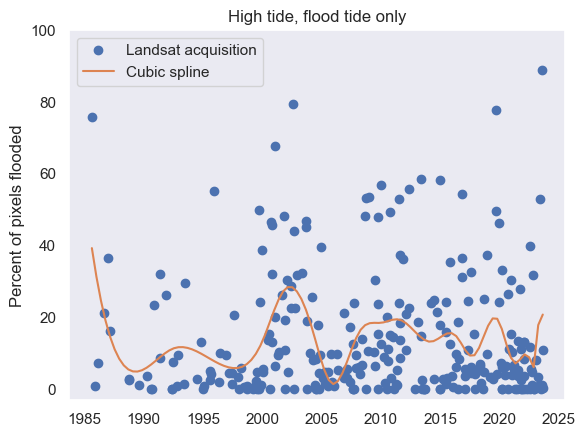

In [158]:
import csaps
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from datetime import datetime


# scipy.interpolate.UnivariateSpline(df_y['Date'], df_y['Percentage'], k = 3)

# sig = df_y[['Date','Percentage']]
df_y['Date'] = pd.to_datetime(df_y['Date'])

y = df_y['Percentage']
x = df_y['ts'] = df_y['Date'].values.astype(np.int64) // 10**6

spline = scipy.interpolate.UnivariateSpline(x, y, k = 3, s = 72000) #72000 works well

# plt.plot(x, y, "o")
# xx = np.linspace(x[0], x[-1], 100)
# plt.plot(xx, spline(xx))
# plt.plot(pd.to_datetime(xx), spline(xx), label='Spline')

df_y['Date_ms'] = df_y['Date'].values.astype(np.int64) // 10**6


# Plotting
plt.plot(df_y['Date'], df_y['Percentage'], "o", label='Landsat acquisition')
xx = np.linspace(df_y['Date_ms'].min(), df_y['Date_ms'].max(), 100)
xx_datetime = pd.to_datetime(xx, unit='ms')
plt.plot(xx_datetime, spline(xx), label='Cubic spline')

# Axis labels and title
plt.xlabel('')
plt.ylabel('Percent of pixels flooded')
plt.title('High tide, flood tide only')

# Remove background gridlines
plt.grid(False)

# Show legend
plt.legend()

plt.ylim(-3,100)

# Show the plot
plt.show()



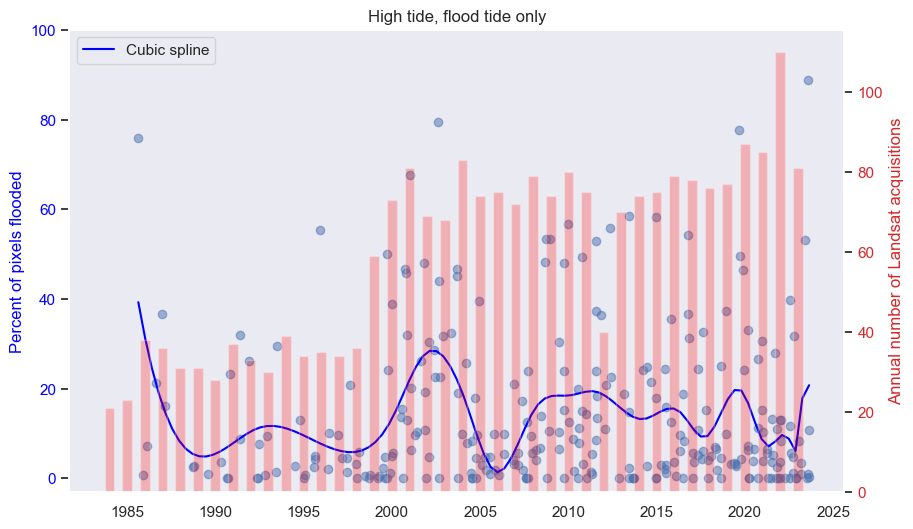

In [219]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# ax1.set_facecolor('none')

# Plot for df_y on the left y-axis
ax1.plot(df_y['Date'], df_y['Percentage'], "o", label='', alpha = 0.5)
xx = np.linspace(df_y['Date_ms'].min(), df_y['Date_ms'].max(), 100)
xx_datetime = pd.to_datetime(xx, unit='ms')
ax1.plot(xx_datetime, spline(xx), label='Cubic spline', color='blue')

# Axis labels and title for the left y-axis
ax1.set_xlabel('')
ax1.set_ylabel('Percent of pixels flooded', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('High tide, flood tide only')

# Create a secondary y-axis on the right
ax2 = ax1.twinx()

# ax2.set_facecolor('none')

# Plot for df_imcount on the right y-axis
ax2.bar(df_imcount['Date'], df_imcount['Image Count'], color='red', width=200, alpha = 0.25, label='Image count')

# Axis labels and title for the right y-axis
ax2.set_ylabel('Annual number of Landsat acquisitions', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set x-axis limits
ax1.set_ylim(-3,100)

# Remove background gridlines
ax1.grid(False)
ax2.grid(False)

# Show legend
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('spline1.png', bbox_inches='tight', dpi = 300)

# Show the plot
plt.show()

In [350]:
df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.8, 1.8, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[(df_x['Tide stage'] == 'Flood') & (df_x['Date'].dt.year > 1984) & (df_x['Tide'] == 'High')]

df_imcount = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/imcount.csv')
df_imcount['Date'] = pd.to_datetime(df_imcount['Year'], format = '%Y')

df_z = df_y[["Date", "Percentage"]].copy()

df_z.set_index('Date', inplace=True)


# Resample to daily frequency and interpolate
daily_data = df_z.resample('M').first().interpolate(method='spline', order = 3) #.first() for some reason makes this all work

# print(daily_data)
print(daily_data)

            Percentage
Date                  
1985-08-31   75.769231
1985-09-30   37.690805
1985-10-31   14.177864
1985-11-30    3.309890
1985-12-31    0.770812
...                ...
2023-04-30   33.947202
2023-05-31   53.083110
2023-06-30   20.227753
2023-07-31    0.000000
2023-08-31   88.888889

[457 rows x 1 columns]


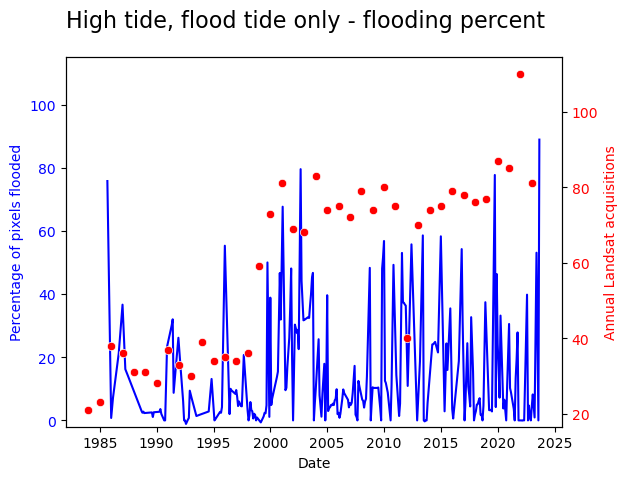

In [349]:
fig, ax1 = plt.subplots()

# Scatter plot for df_y
sns.lineplot(data=daily_data, x="Date", y="Percentage", color='blue', ax=ax1)
ax1.set_ylabel("Percentage of pixels flooded", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.ylim(-2, 115)

# Create a second y-axis for the bar plot of Image_Count from df_imcount
ax2 = ax1.twinx()
sns.scatterplot(data=df_imcount, x="Date", y="Image Count", color='red', ax=ax2)
ax2.set_ylabel("Annual Landsat acquisitions", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.suptitle('High tide, flood tide only - flooding percent', fontsize=16)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('splined.png', bbox_inches='tight', dpi = 300)

plt.show()

In [309]:
daily_data['Date'] = daily_data.index
df_3 = pd.merge(daily_data, df_imcount)
df_3

AttributeError: 'DatetimeIndex' object has no attribute 'reset_Index'

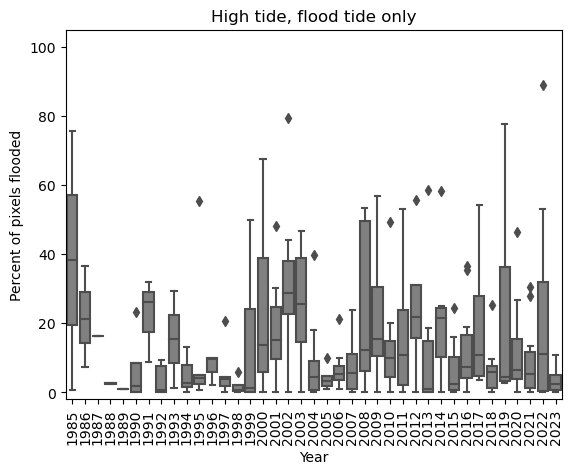

In [337]:
#Flood tide only, high tide only!

df_x['Tide'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0.8, 1.8, 3], labels = ['Low', 'Medium', 'High'])
df_y = df_x[(df_x['Tide stage'] == 'Flood') & (df_x['Date'].dt.year > 1984) & (df_x['Tide'] == 'High')]
# df_y['Date'] = pd.to_datetime(df_y['Date'])
df_y['Year'] = df['Date'].dt.year
df_y['Date2'] = pd.to_datetime(df_y['Date'], format = '%Y')

df_imcount = pd.read_csv('C:/Users/arj26323/Documents/Data/flats/imcount.csv')
df_imcount['Date'] = pd.to_datetime(df_imcount['Year'], format = '%Y')

fig, ax = plt.subplots()

g = sns.boxplot(df_y, x = 'Year', y = 'Percentage', color = 'gray', ax = ax).set(
    xlabel='Year', 
    ylabel='Percent of pixels flooded',
    title='High tide, flood tide only',
    ylim = (-2,105)
)


# Display every nth label on the x-axis (adjust n as needed)
# n = 10
# plt.xticks(range(0, len(df_y['Date']), n), df_y['Date'].dt.strftime('%Y').iloc[::n])
plt.xticks(rotation=90)


# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('boxplotxx.png', bbox_inches='tight', dpi = 300)

plt.show()

In [137]:
# df_y = df_y.reset_index()
df_y['xxx'] = df_y.index

from scipy.interpolate import interp1d

# df_y2 = df_y.dropna() # interpolate on the non nan


df_y['f'] = interp1d(df_y['Date'], df_y2['Percentage'], kind='cubic')

df_y

,level_0,index,Date_x,Percentage,Total_Pixel_Count,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Tide change,Tide stage,Date,intercept,Tide,xxx,f
0,0,26,1985-08-21 15:24:12.506,75.769231,780,1985-08-21,1985/08/21,2023-12-06 16:00:00,2.274,-,2.278,0.372,Flood,1985-08-21 15:24:12.506,1,High,0,<scipy.interpolate._interpolate.interp1d objec...
1,1,30,1985-12-02 15:29:00.234,0.770812,1946,1985-12-02,1985/12/02,2023-12-06 16:00:00,2.187,-,1.915,0.037,Flood,1985-12-02 15:29:00.234,1,High,1,<scipy.interpolate._interpolate.interp1d objec...
2,2,34,1986-02-13 15:21:20.547,7.194245,1946,1986-02-13,1986/02/13,2023-12-06 16:00:00,1.939,-,1.817,0.155,Flood,1986-02-13 15:21:20.547,1,High,2,<scipy.interpolate._interpolate.interp1d objec...
3,3,54,1986-08-24 15:15:54.916,21.223022,1946,1986-08-24,1986/08/24,2023-12-06 16:00:00,2.212,-,2.223,0.128,Flood,1986-08-24 15:15:54.916,1,High,3,<scipy.interpolate._interpolate.interp1d objec...
4,4,63,1986-12-21 15:19:47.276,36.639260,1946,1986-12-21,1986/12/21,2023-12-06 16:00:00,2.060,-,2.333,0.125,Flood,1986-12-21 15:19:47.276,1,High,4,<scipy.interpolate._interpolate.interp1d objec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,276,1646,2022-11-14 16:01:16.491,0.000000,0,2022-11-14,2022/11/14,2023-12-06 16:00:00,2.094,-,2.281,0.265,Flood,2022-11-14 16:01:16.491,1,High,276,<scipy.interpolate._interpolate.interp1d objec...
277,277,1650,2023-01-26 15:55:01.192,8.221994,1946,2023-01-26,2023/01/26,2023-12-06 16:00:00,2.052,-,2.028,0.378,Flood,2023-01-26 15:55:01.192,1,High,277,<scipy.interpolate._interpolate.interp1d objec...
278,278,1659,2023-05-25 16:00:16.596,53.083110,373,2023-05-25,2023/05/25,2023-12-06 16:00:00,1.608,-,2.115,0.251,Flood,2023-05-25 16:00:16.596,1,High,278,<scipy.interpolate._interpolate.interp1d objec...
279,279,1664,2023-08-06 15:54:22.659,88.888889,9,2023-08-06,2023/08/06,2023-12-06 16:00:00,2.235,-,2.528,0.399,Flood,2023-08-06 15:54:22.659,1,High,279,<scipy.interpolate._interpolate.interp1d objec...


In [138]:
# import pandas as pd

# df_u = df_y[['Date', 'Percentage']].copy()

# # Assuming df_y is your DataFrame
# df_u['Time'] = pd.to_datetime(df_u['Date'])  # Convert 'Date' column to datetime, if not already
# df_u.set_index('Time', inplace=True)  # Set 'Date' as the index

# # Resample to monthly frequency and interpolate
# df_resampled = df_u.resample('M')
# interpolated = df_resampled.asfreq().interpolate(method='spline', order=3)

# print(interpolated.head(32))



NotImplementedError: 

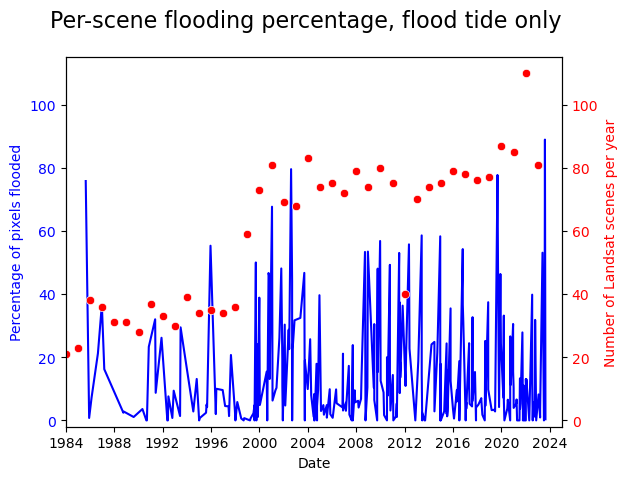

In [144]:
df_y['spline'] = df_y['Percentage'].interpolate(method = 'polynomial', order = 3)

fig, ax1 = plt.subplots()

# Scatter plot for df_y
sns.lineplot(data=df_y, x="Date", y="spline", color='blue', ax=ax1)
ax1.set_ylabel("Percentage of pixels flooded", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.ylim(-2, 115)

# Create a twin y-axis for df_imcount
ax2 = ax1.twinx()
sns.scatterplot(data=df_imcount, x="Date", y="Image Count", color='red', ax=ax2)  # Replace 'YourImCountColumn' with the appropriate column from df_imcount
ax2.set_ylabel("Number of Landsat scenes per year", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.suptitle('Per-scene flooding percentage, flood tide only', fontsize=16)
plt.xlim(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31'))
plt.ylim(-2, 115)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('cerf_variablethresholds2.png', bbox_inches='tight', dpi = 300)

plt.show()

In [97]:
# df_y['Times'] = np.arange(1, len(df_y) + 1)

import pandas as pd

# Convert 'Date' column to datetime
df_y['Date'] = pd.to_datetime(df_y['Date'])

# Convert 'Date' to seconds and then to integers
df_y['seconds'] = pd.to_datetime(df_y['Date'],unit = 'ms').astype('int64')


# Define the start date
start_date = pd.Timestamp('1984-01-01')

# Calculate the difference in years from the start date and convert to int
df_y['start'] = ((df_y['Date'] - start_date).dt.days / 365.25).astype(int)

# df_y

,Date_x,Percentage,Total_Pixel_Count,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Tide change,Tide stage,Date,intercept,Tide,Times,Increasing_Column,seconds,Years_from_Start,start
21,1985-01-16 15:31:08.685,10.431655,1946,1985-01-16,1985/01/16,2023-11-10 16:00:00,0.086,-,0.199,0.088,Flood,1985-01-16 15:31:08.685,1,Low,1,1,474737468685000000,1,1
24,1985-07-27 15:30:38.153,25.000000,4,1985-07-27,1985/07/27,2023-11-10 16:00:00,0.198,-,0.150,0.250,Flood,1985-07-27 15:30:38.153,1,Low,2,2,491326238153000000,1,1
25,1985-08-12 15:30:29.139,2.302379,1303,1985-08-12,1985/08/12,2023-11-10 16:00:00,0.273,-,0.406,0.018,Flood,1985-08-12 15:30:29.139,1,Low,3,3,492708629139000000,1,1
26,1985-08-21 15:24:12.506,75.769231,780,1985-08-21,1985/08/21,2023-11-10 16:00:00,2.274,-,2.278,0.372,Flood,1985-08-21 15:24:12.506,1,High,4,4,493485852506000000,1,1
27,1985-09-06 15:24:00.739,0.551876,1812,1985-09-06,1985/09/06,2023-11-10 16:00:00,1.898,-,1.732,0.314,Flood,1985-09-06 15:24:00.739,1,Medium,5,5,494868240739000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,2023-05-25 16:00:16.596,53.083110,373,2023-05-25,2023/05/25,2023-11-10 16:00:00,1.608,-,2.115,0.251,Flood,2023-05-25 16:00:16.596,1,High,748,748,1685030416596000000,39,39
1660,2023-06-26 16:00:08.772,22.489540,1912,2023-06-26,2023/06/26,2023-11-10 16:00:00,1.236,-,1.452,0.385,Flood,2023-06-26 16:00:08.772,1,Medium,749,749,1687795208772000000,39,39
1662,2023-07-12 16:00:23.748,12.938331,827,2023-07-12,2023/07/12,2023-11-10 16:00:00,0.216,-,0.569,0.282,Flood,2023-07-12 16:00:23.748,1,Low,750,750,1689177623748000000,39,39
1664,2023-08-06 15:54:22.659,88.888889,9,2023-08-06,2023/08/06,2023-11-10 16:00:00,2.235,-,2.528,0.399,Flood,2023-08-06 15:54:22.659,1,High,751,751,1691337262659000000,39,39


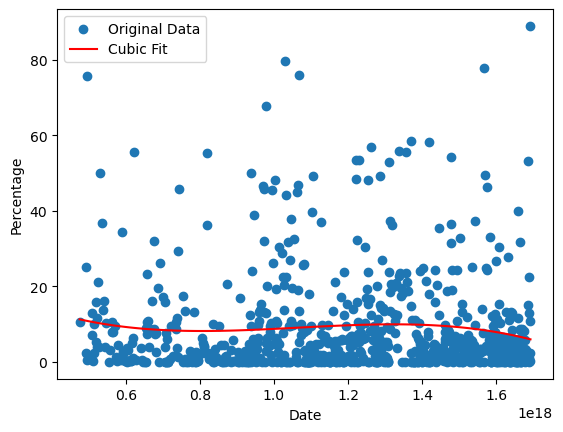

In [104]:
from datetime import datetime

from scipy.interpolate import CubicSpline
dates = df_y['seconds']
percentage = df_y['Percentage']
# dates_ms = np.array([date.timestamp() * 1000 for date in dates])

# Fit a cubic polynomial (degree=3) to the data
coefficients = np.polyfit(dates, percentage, 3)

# Create a polynomial function using the obtained coefficients
cubic_fit = np.poly1d(coefficients)

# Generate values for the cubic fit curve
fit_dates = np.linspace(min(dates), max(dates), 100)
fit_percentage = cubic_fit(fit_dates)

# Plot the original data and the cubic fit
plt.scatter(dates, percentage, label='Original Data')
plt.plot(fit_dates, fit_percentage, label='Cubic Fit', color='red')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.show()




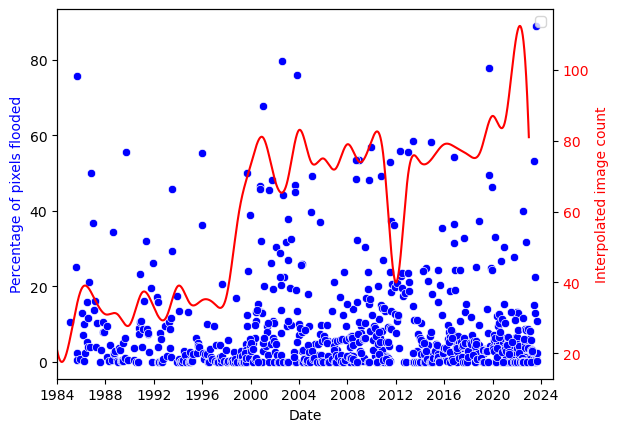

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Sort the data by 'Date' for df_imcount
df_imcount = df_imcount.sort_values('Date')

# Perform cubic spline interpolation on df_imcount
cs_imcount = CubicSpline(df_imcount['Date'], df_imcount['Image Count'])

# Generate a sequence of interpolated x values (common Date range)
x_new = pd.date_range(df_imcount['Date'].min(), df_imcount['Date'].max(), freq='D')

# Calculate interpolated y values for df_imcount
y_interp_imcount = cs_imcount(x_new)

# Plot the interpolated curve for df_imcount
fig, ax1 = plt.subplots()

# Scatter plot for df_y (Percentage)
sns.scatterplot(data=df_y, x="Date", y="Percentage", marker='o', color='blue', ax=ax1)
ax1.set_ylabel("Percentage of pixels flooded", color='blue')

# Create a twin y-axis for the interpolated df_imcount
ax2 = ax1.twinx()
ax2.plot(x_new, y_interp_imcount, color='red', label='')
ax2.set_ylabel("Interpolated image count", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# plt.suptitle('Scatterplot for df_y and Cubic Spline Interpolated df_imcount', fontsize=16)
plt.xlim(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31'))

# Show legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()


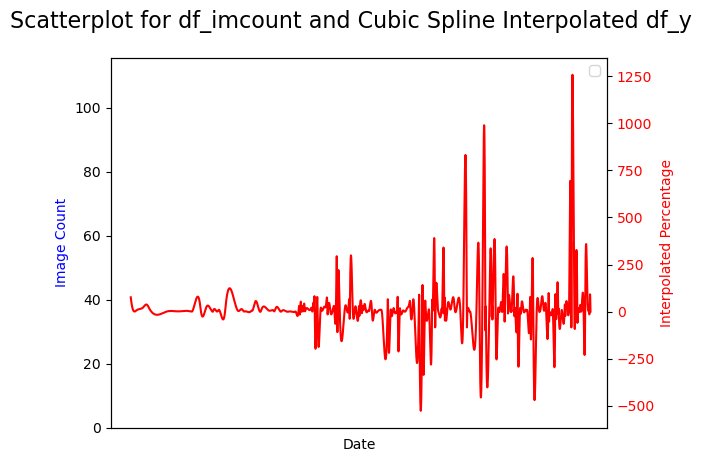

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import make_interp_spline


# Sort the data by 'Date' for df_y
df_y = df_y.sort_values('Date')

# Perform cubic spline interpolation on df_y
cs_y = CubicSpline(df_y['Date'], df_y['Percentage'])

# Generate a sequence of interpolated x values (common Date range)
x_new = pd.date_range(df_y['Date'].min(), df_y['Date'].max(), freq='D')

# Calculate interpolated y values for df_y
y_interp_y = cs_y(x_new)

# Plot the interpolated curve for df_y
fig, ax1 = plt.subplots()

# Scatter plot for df_imcount
sns.barplot(data=df_imcount, x="Date", y="Image Count", color='blue', ax=ax1)
ax1.set_ylabel("Image Count", color='blue')

# Create a twin y-axis for the interpolated df_y
ax2 = ax1.twinx()
ax2.plot(x_new, y_interp_y, color='red', label='')
ax2.set_ylabel("Interpolated Percentage", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.suptitle('Scatterplot for df_imcount and Cubic Spline Interpolated df_y', fontsize=16)
plt.xlim(pd.to_datetime('1984-01-01'), pd.to_datetime('2024-12-31'))

# Show legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()


In [56]:
#DEM
region = flux_ga
dem = elevation
# dem_df = geemap.ee_to_pandas(dem.addBands(dem.pixelLonLat()).sampleRegions(collection = region, scale = 10, geometries = True))

# print(dem_df)

In [57]:
# dem_df['elevation'].hist(bins = 55)

In [58]:
# # elevation = dem.clip(flux_ga)

# # Define the elevation range
# elevation_range = [0, 0.79]
# elevation_range2 = [0.79, 0.87]
# elevation_range3 = [0.87, 0.94]
# elevation_range4 = [0.94, 1.3]


# # Create a mask for the elevation range
# elevation_mask = elevation.gte(elevation_range[0]).And(elevation.lt(elevation_range[1]))
# elevation_mask2 = elevation.gte(elevation_range2[0]).And(elevation.lt(elevation_range2[1]))
# elevation_mask3 = elevation.gte(elevation_range3[0]).And(elevation.lt(elevation_range3[1]))
# elevation_mask4 = elevation.gte(elevation_range4[0]).And(elevation.lt(elevation_range4[1]))


# # Mask the DEM to retain only the specified elevation range
# elevation_low = elevation.updateMask(elevation_mask)
# elevation_medlow = elevation.updateMask(elevation_mask2)
# elevation_medhigh = elevation.updateMask(elevation_mask3)
# elevation_high = elevation.updateMask(elevation_mask4)

# # Add the elevation range raster to the map for visualization
# Map.addLayer(elevation_low, {
#     'min': elevation_range[0],
#     'max': elevation_range[1],
#     'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
# }, 'Low')

# Map.addLayer(elevation_medlow, {
#     'min': elevation_range[0],
#     'max': elevation_range[1],
#     'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
# }, 'medlow')

# Map.addLayer(elevation_medhigh, {
#     'min': elevation_range[0],
#     'max': elevation_range[1],
#     'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
# }, 'medhigh')

# Map.addLayer(elevation_high, {
#     'min': elevation_range[0],
#     'max': elevation_range[1],
#     'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
# }, 'High')

# # Display the map
# Map

Map(bottom=107150.0, center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent…

In [59]:
# Map.addLayer(x, vis_param, 'SR')

# xm = x.mask(elevation_low)

# Map.addLayer(xm, vis_param, 'mask')

# Map

In [60]:
# #MASKING DIFFERENT ELEVATIONS - note: recycled variables, be careful!
# #Also note: RESAMPLES LANDSAT PIXELS TO 10 M, AFFECTING PIXEL COUNT

# elev = elevation_low #CHANGE BASED ON WHAT ELEVATION RANGE YOU WANT TO SEE

# el8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
#     .filterBounds(flux_ga) \
#     .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

# el7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
#     .filterBounds(flux_ga)\
#     .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

# el5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
#     .filterBounds(flux_ga)\
#     .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

# el9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
#     .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
#     .filterBounds(flux_ga)\
#     .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

# # l8
# eperflood_l8 = el8_col.map(calculate_percentage)
# edates = eperflood_l8.aggregate_array('system:time_start')
# epercentages = eperflood_l8.aggregate_array('percentage_flood')
# etotal_pixel_counts = eperflood_l8.aggregate_array('total_pixel_count')
# edates_list = edates.getInfo()
# epercentages_list = epercentages.getInfo()
# etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
# edf8 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
# edf8['Date'] = pd.to_datetime(edf8['Date'], unit='ms')
# edf8 = edf8.sort_values(by='Date')

# #l5
# eperflood_l5 = el5_col.map(calculate_percentage)
# edates = eperflood_l5.aggregate_array('system:time_start')
# epercentages = eperflood_l5.aggregate_array('percentage_flood')
# etotal_pixel_counts = eperflood_l5.aggregate_array('total_pixel_count')
# edates_list = edates.getInfo()
# epercentages_list = epercentages.getInfo()
# etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
# edf5 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
# edf5['Date'] = pd.to_datetime(edf5['Date'], unit='ms')
# edf5 = edf5.sort_values(by='Date')

# #l7
# eperflood_l7 = el7_col.map(calculate_percentage)
# edates = eperflood_l7.aggregate_array('system:time_start')
# epercentages = eperflood_l7.aggregate_array('percentage_flood')
# etotal_pixel_counts = eperflood_l7.aggregate_array('total_pixel_count')
# edates_list = edates.getInfo()
# epercentages_list = epercentages.getInfo()
# etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
# edf7 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
# edf7['Date'] = pd.to_datetime(edf7['Date'], unit='ms')
# edf7 = edf7.sort_values(by='Date')

# #l9
# eperflood_l9 = el9_col.map(calculate_percentage)
# edates = eperflood_l9.aggregate_array('system:time_start')
# epercentages = eperflood_l9.aggregate_array('percentage_flood')
# etotal_pixel_counts = eperflood_l9.aggregate_array('total_pixel_count')
# edates_list = edates.getInfo()
# epercentages_list = epercentages.getInfo()
# etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
# edf9 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
# edf9['Date'] = pd.to_datetime(edf9['Date'], unit='ms')
# edf9 = edf9.sort_values(by='Date')

# edf = pd.concat([edf5,edf7,edf8,edf9], axis=0)
# edf = edf.reset_index(drop=True)

# edf['DOY'] = edf['Date'].dt.strftime('%Y-%m-%d')
# edf['DOY'] = pd.to_datetime(edf['DOY'])
# edf

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-04-12 15:21:47.367,1.664533,781,1984-04-12
1,1984-04-19 15:27:58.365,43.405890,781,1984-04-19
2,1984-05-05 15:28:05.134,4.481434,781,1984-05-05
3,1984-05-14 15:22:12.295,11.907810,781,1984-05-14
4,1984-05-21 15:28:35.468,3.072983,781,1984-05-21
...,...,...,...,...
2372,2023-08-29 16:00:43.797,0.000000,781,2023-08-29
2373,2023-09-07 15:54:38.470,7.810499,781,2023-09-07
2374,2023-09-14 16:00:52.757,17.413572,781,2023-09-14
2375,2023-09-23 15:54:40.118,17.669654,781,2023-09-23


In [61]:
# edf_combined = pd.merge(edf, df_time, on = 'DOY')
# edf_combined['Date'] = edf_combined['Date_x']
# edf_combined

,Date_x,Percentage,Total_Pixel_Count,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Date
0,1984-04-12 15:21:47.367,1.664533,781,1984-04-12,1984/04/12,2023-10-09 16:00:00,-0.025,-,0.126,1984-04-12 15:21:47.367
1,1984-04-19 15:27:58.365,43.405890,781,1984-04-19,1984/04/19,2023-10-09 16:00:00,2.053,-,2.009,1984-04-19 15:27:58.365
2,1984-05-05 15:28:05.134,4.481434,781,1984-05-05,1984/05/05,2023-10-09 16:00:00,1.853,-,1.848,1984-05-05 15:28:05.134
3,1984-05-14 15:22:12.295,11.907810,781,1984-05-14,1984/05/14,2023-10-09 16:00:00,0.642,-,0.257,1984-05-14 15:22:12.295
4,1984-05-21 15:28:35.468,3.072983,781,1984-05-21,1984/05/21,2023-10-09 16:00:00,1.473,-,1.397,1984-05-21 15:28:35.468
...,...,...,...,...,...,...,...,...,...,...
2372,2023-08-29 16:00:43.797,0.000000,781,2023-08-29,2023/08/29,2023-10-09 16:00:00,0.211,-,0.488,2023-08-29 16:00:43.797
2373,2023-09-07 15:54:38.470,7.810499,781,2023-09-07,2023/09/07,2023-10-09 16:00:00,1.366,-,-,2023-09-07 15:54:38.470
2374,2023-09-14 16:00:52.757,17.413572,781,2023-09-14,2023/09/14,2023-10-09 16:00:00,1.062,-,-,2023-09-14 16:00:52.757
2375,2023-09-23 15:54:40.118,17.669654,781,2023-09-23,2023/09/23,2023-10-09 16:00:00,1.470,-,-,2023-09-23 15:54:40.118


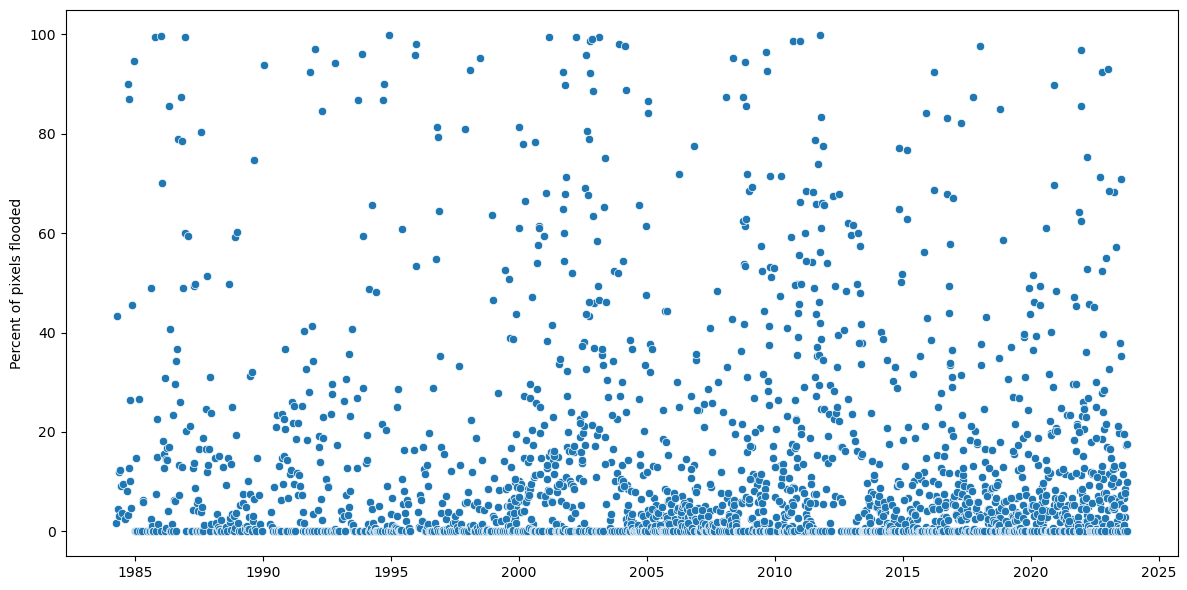

In [62]:
# edf_ultra = edf_combined[edf_combined['Total_Pixel_Count'] >= 30]

# plt.figure(figsize=(12, 6))

# import seaborn as sns
# ax = sns.scatterplot(
#     x="Date",
#     y="Percentage",
#     legend=False,
#     marker = 'o',
#     data=edf_ultra
# )

# plt.ylabel("Percent of pixels flooded")
# plt.xlabel("")

# plt.tight_layout()

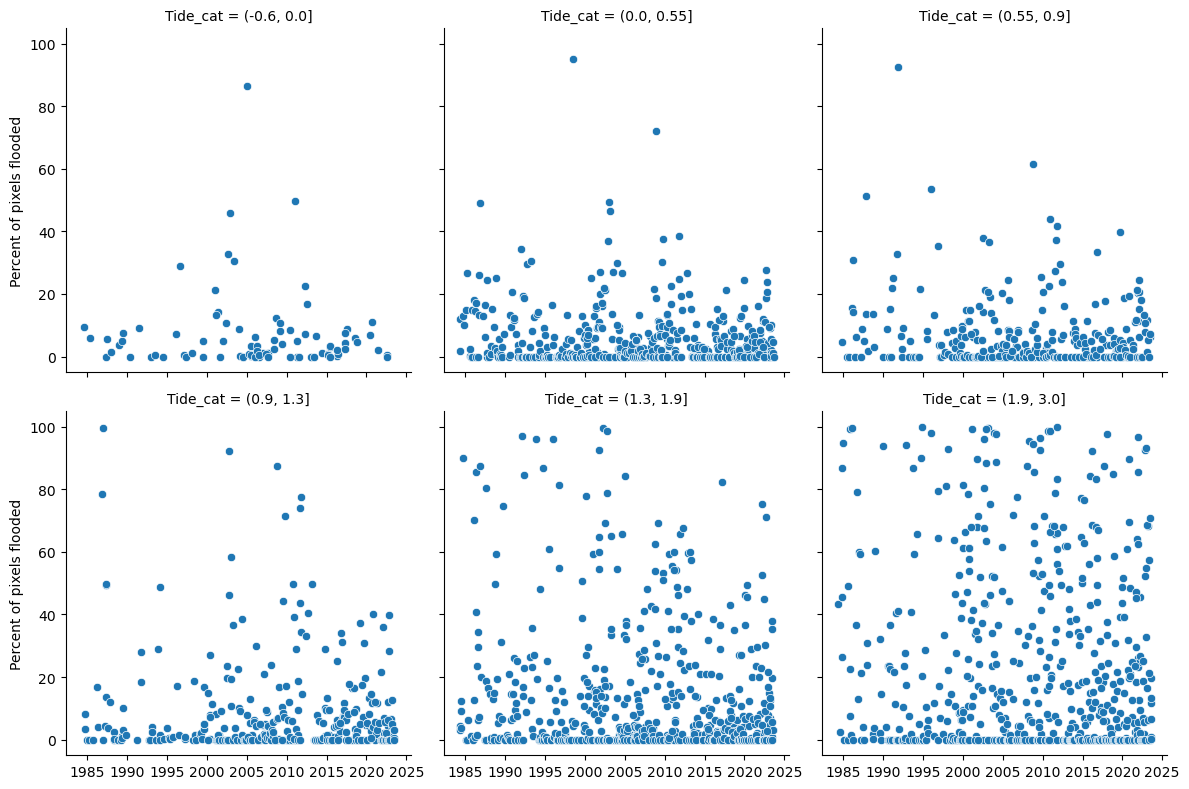

In [63]:
# # Add a constant term to the DataFrame for the intercept
# edf_x = edf_ultra.copy()

# edf_x['Verified (m)'] = edf_x['Verified (m)'].replace('-', float('nan')).astype('float')

# edf_x = edf_x.dropna()

# edf_x['Date'] = pd.to_datetime(edf_x['Date'])

# edf_x['intercept'] = 1

# import math
# # edf_x['log_percent'] = math.log(edf_x['Percentage'])

# # Create a facet grid for 'Verified (m)' categories

# edf_x['Tide_cat'] = pd.cut(edf_x['Verified (m)'], bins = [-0.6, 0, 0.55, 0.9, 1.3, 1.9, 3])

# g = sns.FacetGrid(edf_x, col="Tide_cat", col_wrap=3, height=4)
# g.map(sns.scatterplot, "Date", "Percentage", marker='o', legend=False)

# # Set axis labels and adjust layout
# g.set_axis_labels("", "Percent of pixels flooded")
# g.tight_layout()
# plt.show()

# # Savefig
# import os
# os.chdir("C:/Users/arj26323/Downloads")
# # g.savefig('high_elev.png', bbox_inches='tight', dpi = 300)

In [64]:
#Currently, far more pixels in low elev than any of the others - take another look at the histogram


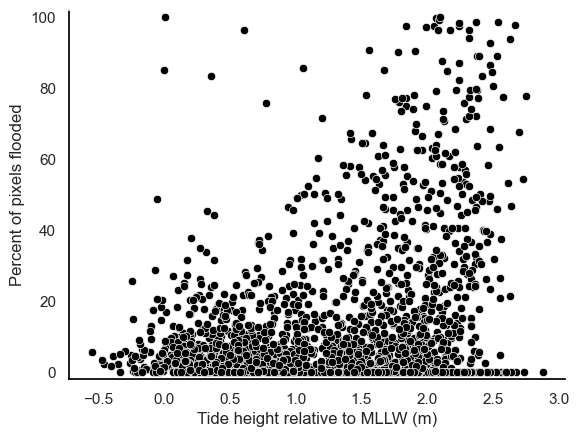

In [244]:
#Plot: percent flooding ~ MLLW

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

g = sns.scatterplot(data = df_x, x="Verified (m)", y="Percentage", color = 'black').set( 
    xlabel='Tide height relative to MLLW (m)', 
    ylabel='Percent of pixels flooded'
)

# Set axis labels and adjust layout
# g.set_axis_labels("Tide height relative to MLLW (m)", "Percent of pixels flooded")
S
plt.ylim(-2,102)
ax.set_facecolor('white')

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('mllwpercent.png',bbox_inches='tight', dpi = 300)

plt.show()